In [4]:
import copy
import json
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import math
import re


In [5]:
root_dir = "/home/kirill/Documents/1.Projects/" \
           "class-ranking/intellij-community/" \
           "project-processing-results/processing/" \
           "java/classes/processing/0.0.1/"

cnt = 0
individualUsages = {}  # {className -> {className -> count}}
graph = {}  #{className -> [parentNames]}

def good(usage) -> bool:
    # {'TYPE', 'THIS_EXPRESSION', 'EXTENDS_LIST', 'IMPLEMENTS_LIST', 'METHOD_REF_EXPRESSION', 'EXPRESSION_LIST', 'NEW_EXPRESSION', 'CONDITIONAL_EXPRESSION', 'FIELD', 'ANNOTATION', 'THROWS_LIST', 'SUPER_EXPRESSION', 'JAVA_CODE_REFERENCE', 'REFERENCE_EXPRESSION', 'DOC_REFERENCE_HOLDER'}
    if usage["features"]["referenceType"] == "ANNOTATION":
        return False
    if usage["features"]["referenceType"] == "DOC_REFERENCE_HOLDER":
        return False
    return True

def addToUsages(data, individualUsages):
    enclosingName = data["keyInfo"]["name"]
    c = Counter()
    for usage in data['usages']:
        if good(usage):
            c.update([usage['name']])
    individualUsages[enclosingName] = c

def addToGraph(data, graph):
    enclosingName = data["keyInfo"]["name"]
    extends = data["keyInfo"]["additionalInfo"]["enclosingClassExtendsList"]
    impls = data["keyInfo"]["additionalInfo"]["enclosingClassImplementsList"]
    if enclosingName not in graph:
        graph[enclosingName] = set()
    for par in (extends + impls):
        if par not in graph:
            graph[par] = set()
        graph[par].update({enclosingName})


print(f'load files, build a graph, count indevidual usages ')
for filename in glob.glob(root_dir + '**/*.json', recursive=True):
    #print(f'name {filename}')
    with open(os.path.join(os.getcwd(), filename), 'r') as f:
        data = json.load(f)
        addToUsages(data, individualUsages)
        addToGraph(data, graph)
        cnt += 1
        if cnt % 10**4 == 0:
            print(f'{cnt} files loaded, for current file: direct_usages = {len(individualUsages[data["keyInfo"]["name"]])} | direct_children = {len(graph[data["keyInfo"]["name"]])} ')
print(f'{cnt} files processed ')

load files, build a graph, count indevidual usages 
10000 files loaded, for current file: direct_usages = 6 | direct_children = 0 
20000 files loaded, for current file: direct_usages = 10 | direct_children = 0 
30000 files loaded, for current file: direct_usages = 2 | direct_children = 0 
40000 files loaded, for current file: direct_usages = 5 | direct_children = 0 
50000 files loaded, for current file: direct_usages = 2 | direct_children = 0 
53265 files processed 


In [6]:
def getTopUsedClassesNumber(counter: Counter, ratio = 0.9) -> int:
    """
    :param counter: class usages
    :param ratio: parameter for metric
    :return: the number of classes used, which occupy 90% of all class usages
    """
    need = math.ceil(sum(counter.values()) * ratio)
    cnt = 0
    for k, v in counter.most_common():
        cnt += 1
        need -= v
        if need <= 0:
            break
    return cnt



familyUsages = {} # className -> usages in all children (className -> number)
family = {} # className -> self and all children set(className)
parent = {} # className -> className
def dfs(v):
    cur_usages = copy.deepcopy(individualUsages[v])
    cur_family_set = {v}
    for u in graph[v]:
        if u not in family:
            parent[u] = v
            dfs(u)

        u_usages, u_child_set = familyUsages[u], family[u]
        cur_usages.update(u_usages)
        cur_family_set.update(u_child_set)
    familyUsages[v], family[v] = cur_usages, cur_family_set


v_count = 0
for v in individualUsages:
    if v not in familyUsages:
        dfs(v)
    v_count += 1
    if v_count % 10**4 == 0:
        print(f'{v_count} vertexes evalueted | in {v} used {len(familyUsages[v])} classes, {len(family[v])} children')

10000 vertexes evalueted | in com.intellij.openapi.externalSystem.model.execution.ExternalSystemTaskExecutionSettings used 6 classes, 1 children
20000 vertexes evalueted | in com.intellij.codeInspection.SimplifyCollectorInspection used 10 classes, 1 children
30000 vertexes evalueted | in com.intellij.refactoring.changeSignature.ChangeSignatureParameterUsageInfo used 2 classes, 1 children
40000 vertexes evalueted | in com.intellij.structuralsearch.impl.matcher.MatchResultImpl used 5 classes, 1 children
50000 vertexes evalueted | in com.intellij.execution.actions.ChooseDebugConfigurationPopupAction used 2 classes, 1 children


In [7]:
print('check sizes')
print(f'len(individualUsages) = {len(individualUsages)} | len(graph) = {len(graph)}')
print(f'len(familyUsages) = {len(familyUsages)} | len(family) = {len(family)} | len(parents) = {len(parent)}')
by_root = set()
by_all = set()
for p in family:
    by_all.update({p})
    if p not in parent:
        by_root.update(family[p])

print(f'count_by_root={len(by_root)} count_individually={len(by_all)} (should be equal)')

check sizes
len(individualUsages) = 53265 | len(graph) = 55151
len(familyUsages) = 53265 | len(family) = 53265 | len(parents) = 23337
count_by_root=53265 count_individually=53265 (should be equal)


In [8]:
print('large families:')
for p in family:
    if len(family[p]) > 1500:
        print(p)

large families:
com.intellij.psi.PsiElement
com.intellij.openapi.util.UserDataHolderBase
com.intellij.openapi.util.UserDataHolderEx
com.intellij.openapi.util.UserDataHolder
com.intellij.openapi.actionSystem.DataProvider
com.intellij.openapi.actionSystem.AnAction
com.intellij.openapi.project.PossiblyDumbAware
com.intellij.codeInsight.intention.FileModifier
com.intellij.testFramework.UsefulTestCase
com.intellij.openapi.project.DumbAware
com.intellij.pom.Navigatable
com.intellij.testFramework.TestIndexingModeSupporter
com.intellij.openapi.util.Iconable
com.intellij.openapi.application.WriteActionAware


In [9]:
print(f'very diverse families (a lot classes used)')
for p in familyUsages:
    if getTopUsedClassesNumber(familyUsages[p], 0.9) > 1500:
        print(f'{p} | TopUsedClassesNumber={getTopUsedClassesNumber(familyUsages[p], 0.9)} | family size = {len(family[p])}')

very diverse families (a lot classes used)
com.intellij.openapi.util.UserDataHolderBase | TopUsedClassesNumber=1773 | family size = 1603
com.intellij.openapi.util.UserDataHolderEx | TopUsedClassesNumber=1774 | family size = 1636
com.intellij.openapi.Disposable | TopUsedClassesNumber=3885 | family size = 1494
com.intellij.openapi.actionSystem.DataProvider | TopUsedClassesNumber=2431 | family size = 1667
com.intellij.openapi.actionSystem.AnAction | TopUsedClassesNumber=1910 | family size = 2810
com.intellij.openapi.project.PossiblyDumbAware | TopUsedClassesNumber=2064 | family size = 2915
com.intellij.testFramework.UsefulTestCase | TopUsedClassesNumber=2080 | family size = 3604
com.intellij.openapi.project.DumbAware | TopUsedClassesNumber=1915 | family size = 2190


In [10]:

def print_points(
        familySizeBounds=(0, 10 ** 9),
        topUsedClassesBounds=(0, 10 ** 9),
        logAxes=(False, False),
        roots_only=False,
        print_graph=True,
        prefix=None
):
    x, y, sz = [], [], []
    cnt_good = 0
    cnt_all = 0
    cnt_children=0
    for p in family:
        cnt_all += 1
        yi, xi = getTopUsedClassesNumber(familyUsages[p]), len(family[p])
        if prefix is not None and not p.startswith(prefix):
            continue
        if not (familySizeBounds[0] <= xi < familySizeBounds[1] and topUsedClassesBounds[0] <= yi < topUsedClassesBounds[1]):
            continue
        if roots_only and p in parent:
            continue
        cnt_good += 1
        cnt_children += xi
        x.append(xi)
        y.append(yi)
        #sz.append(int(10*yi / (1+len(familyUsages[p])))**2)
    print(f'{familySizeBounds[0]} <= children < {familySizeBounds[1]} and {topUsedClassesBounds[0]} <= classes_used < {topUsedClassesBounds[1]} #-# roots_only={roots_only} #-# cnt_children={cnt_children}')
    print(f'percent = {cnt_good / cnt_all} | cnt_good = {cnt_good} | cnt_all = {cnt_all}')
    if not print_graph:
        return
    plt.figure(figsize=(25,10))
    plt.xlabel('family size (кол-во потомков включая себя)')
    plt.ylabel('topUsedClassesNumber(0.9)')
    plt.scatter(x, y, label='root of the family (class)')
    plt.legend()
    if logAxes[0]:
        plt.xscale('log')
    if logAxes[1]:
        plt.yscale('log')
    plt.show()



0 <= children < 1000000000 and 0 <= classes_used < 1000000000 #-# roots_only=False #-# cnt_children=174058
percent = 1.0 | cnt_good = 53265 | cnt_all = 53265


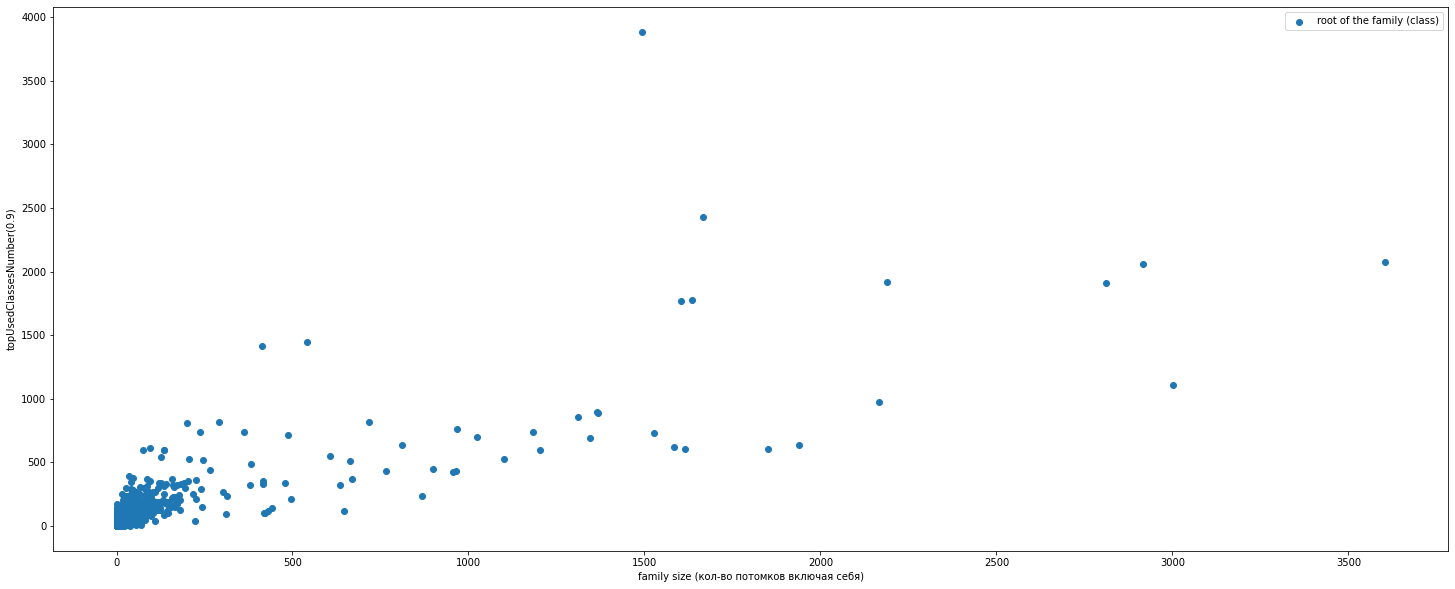

In [11]:
print_points()

0 <= children < 1000000000 and 0 <= classes_used < 1000000000 #-# roots_only=False #-# cnt_children=174058
percent = 1.0 | cnt_good = 53265 | cnt_all = 53265


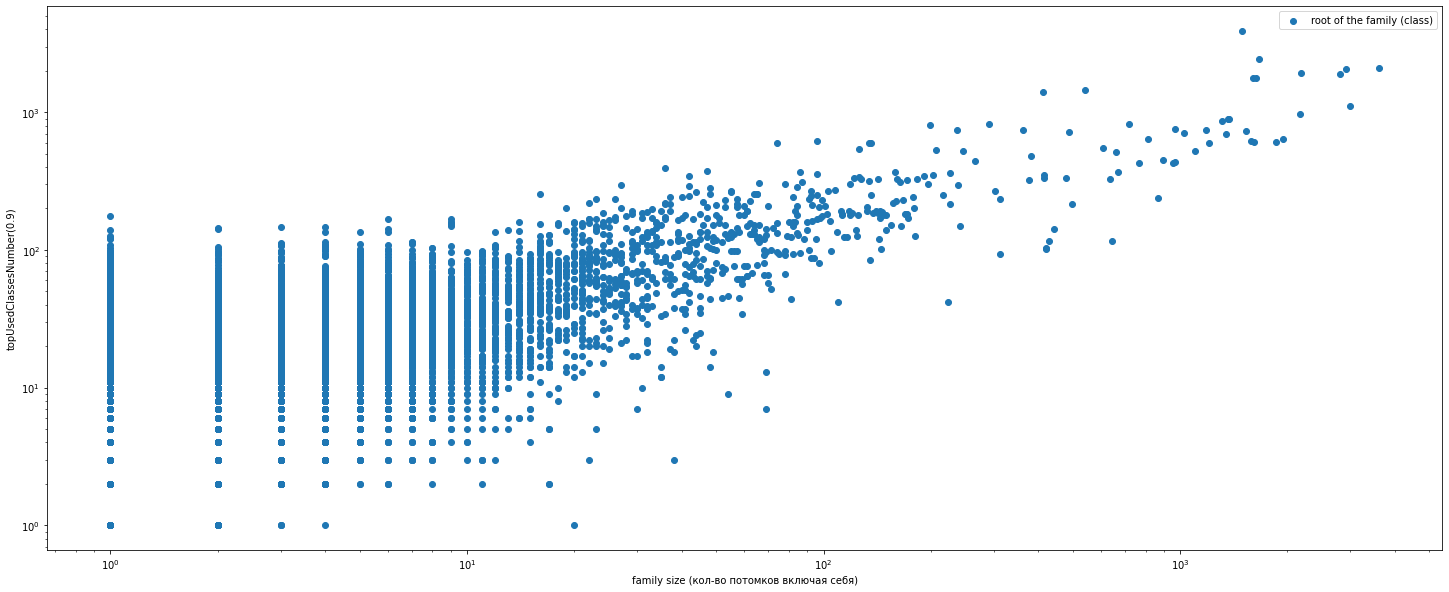

In [12]:
print_points(logAxes=(True, True))

In [13]:
print('outliers')
for p in family:
    yi, xi = getTopUsedClassesNumber(familyUsages[p]), len(family[p])
    if yi > 1000 or xi > 3000:
        print(f'### {p} --> top {yi} | all {len(familyUsages[p])} | children {len(family[p])}')


outliers
### com.intellij.openapi.components.PersistentStateComponent --> top 1413 | all 2608 | children 412
### com.intellij.openapi.util.UserDataHolderBase --> top 1773 | all 4629 | children 1603
### com.intellij.openapi.util.UserDataHolderEx --> top 1774 | all 4679 | children 1636
### com.intellij.openapi.util.UserDataHolder --> top 1110 | all 5508 | children 3002
### com.intellij.openapi.Disposable --> top 3885 | all 8667 | children 1494
### com.intellij.openapi.actionSystem.DataProvider --> top 2431 | all 6088 | children 1667
### com.intellij.openapi.actionSystem.AnAction --> top 1910 | all 4776 | children 2810
### com.intellij.openapi.project.PossiblyDumbAware --> top 2064 | all 5140 | children 2915
### com.intellij.testFramework.UsefulTestCase --> top 2080 | all 6078 | children 3604
### com.intellij.openapi.ui.DialogWrapper --> top 1449 | all 2836 | children 541
### com.intellij.openapi.project.DumbAware --> top 1915 | all 4513 | children 2190


In [14]:
#print_points(familySizeBounds=(1, 10 ** 2), roots_only=True)

In [15]:
print_points(familySizeBounds=(1, 10 ** 9), topUsedClassesBounds=(0, 10 ** 9), print_graph=False)
print_points(familySizeBounds=(2, 10 ** 9), topUsedClassesBounds=(0, 10 ** 9), print_graph=False)
print_points(familySizeBounds=(3, 10 ** 2), topUsedClassesBounds=(0, 10 ** 9), print_graph=False)

1 <= children < 1000000000 and 0 <= classes_used < 1000000000 #-# roots_only=False #-# cnt_children=174058
percent = 1.0 | cnt_good = 53265 | cnt_all = 53265
2 <= children < 1000000000 and 0 <= classes_used < 1000000000 #-# roots_only=False #-# cnt_children=130903
percent = 0.18980568853843988 | cnt_good = 10110 | cnt_all = 53265
3 <= children < 100 and 0 <= classes_used < 1000000000 #-# roots_only=False #-# cnt_children=52509
percent = 0.11219374823993242 | cnt_good = 5976 | cnt_all = 53265


In [16]:
#print_points(familySizeBounds=(0, 10 ** 9), topUsedClassesBounds=(0, 10 ** 9), roots_only=True, print_graph=True, prefix="com.intellij.ui.")

In [17]:
def check_package(prefix=None, ratio = 0.9):
    cnt_good = 0
    cnt_all = 0
    counter_all = Counter()
    for p in family:
        cnt_all += 1
        if prefix is not None and not p.startswith(prefix):
            continue
        cnt_good += 1
        counter_all.update(individualUsages[p])


        #sz.append(int(10*yi / (1+len(familyUsages[p])))**2)
    print('info about prefix:')
    print(f'{prefix} -> percent = {cnt_good / cnt_all} | classes with prefix = {cnt_good} | all classes = {cnt_all}')
    print(f'{prefix} -> topUsedClassesNumber({ratio}) = {getTopUsedClassesNumber(counter_all, ratio)}')
    print(f' classes used in prefix = {len(counter_all)} | usages in prefix = {sum(counter_all.values())}')
    print()

In [18]:
check_package(prefix="com.intellij.ui.", ratio=0.7)
check_package(prefix="com.intellij.ui.", ratio=0.8)
check_package(prefix="com.intellij.ui.", ratio=0.9)

check_package(prefix="com.intellij.ide.", ratio=0.9)

check_package(prefix="com.intellij.psi.", ratio=0.9)

check_package(prefix="org.editorconfig.", ratio=0.9)

check_package(prefix="com.intellij.lang.", ratio=0.9)


info about prefix:
com.intellij.ui. -> percent = 0.025945742983197222 | classes with prefix = 1382 | all classes = 53265
com.intellij.ui. -> topUsedClassesNumber(0.7) = 321
 classes used in prefix = 2135 | usages in prefix = 20722

info about prefix:
com.intellij.ui. -> percent = 0.025945742983197222 | classes with prefix = 1382 | all classes = 53265
com.intellij.ui. -> topUsedClassesNumber(0.8) = 542
 classes used in prefix = 2135 | usages in prefix = 20722

info about prefix:
com.intellij.ui. -> percent = 0.025945742983197222 | classes with prefix = 1382 | all classes = 53265
com.intellij.ui. -> topUsedClassesNumber(0.9) = 945
 classes used in prefix = 2135 | usages in prefix = 20722

info about prefix:
com.intellij.ide. -> percent = 0.04881254106824369 | classes with prefix = 2600 | all classes = 53265
com.intellij.ide. -> topUsedClassesNumber(0.9) = 1731
 classes used in prefix = 4582 | usages in prefix = 56077

info about prefix:
com.intellij.psi. -> percent = 0.04881254106824369 

In [19]:
'com.intellij.openapi.actionSystem.AnAction'
def print_topUsedByRatio(
        name = None,
        logAxes=(False, False),
        classCounter=None,
        figsize=(15,5)
):
    classesUsed = len(classCounter[name])
    print(f'{name} | classes used {classesUsed} | usages {sum(classCounter[name].values())} | family size = {len(family[name])}')

    x, y = [], []

    x = np.linspace(0, 1, 100)
    y_data = [getTopUsedClassesNumber(classCounter[name], xi) for xi in x]
    y_hypo = [classesUsed**xi for xi in x]

    plt.figure(figsize=figsize)
    plt.xlabel('ratio')
    plt.ylabel('topUsedClassesNumber(ratio)')
    plt.scatter(x, y_data, label='data')
    plt.scatter(x, y_hypo, label=f'{classesUsed}^x')
    if logAxes[0]:
        plt.xscale('log')
    if logAxes[1]:
        plt.yscale('log')
    plt.legend()
    plt.show()


In [20]:
familyClassesUsed = {} # className -> used classes (className -> number)
for cur_family in family:
    cur_count = Counter()
    for member in family[cur_family]:
        cur_count.update(Counter(individualUsages[member].keys()))
    familyClassesUsed[cur_family] = cur_count

In [21]:
def print_usagesRatioInfo(name=None):
    print(f'familyUsages:')
    print_topUsedByRatio(name, logAxes=(False, True), classCounter=familyUsages)

    print(f'familyClassesUsed:')
    print_topUsedByRatio(name, logAxes=(False, True), classCounter=familyClassesUsed)

familyUsages:
com.intellij.openapi.actionSystem.AnAction | classes used 4776 | usages 42966 | family size = 2810


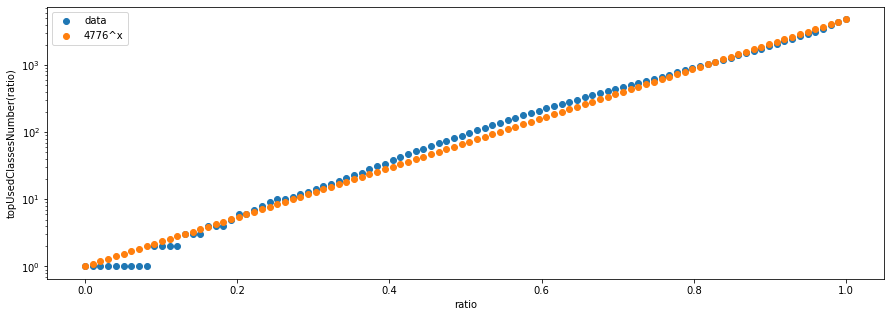

familyClassesUsed:
com.intellij.openapi.actionSystem.AnAction | classes used 4776 | usages 24588 | family size = 2810


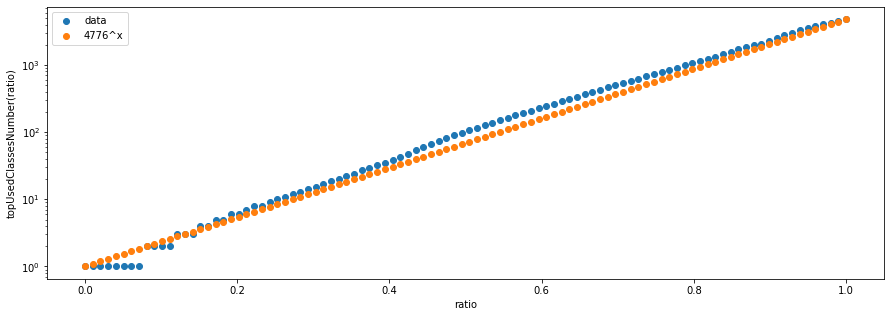

In [22]:
print_usagesRatioInfo('com.intellij.openapi.actionSystem.AnAction')

familyUsages:
com.intellij.openapi.Disposable | classes used 8667 | usages 78832 | family size = 1494


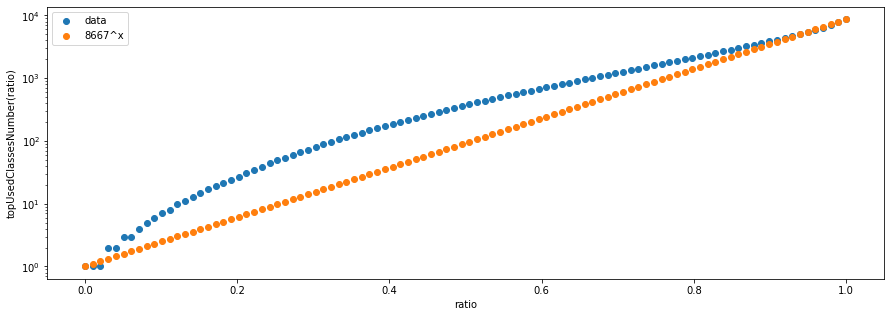

familyClassesUsed:
com.intellij.openapi.Disposable | classes used 8667 | usages 28225 | family size = 1494


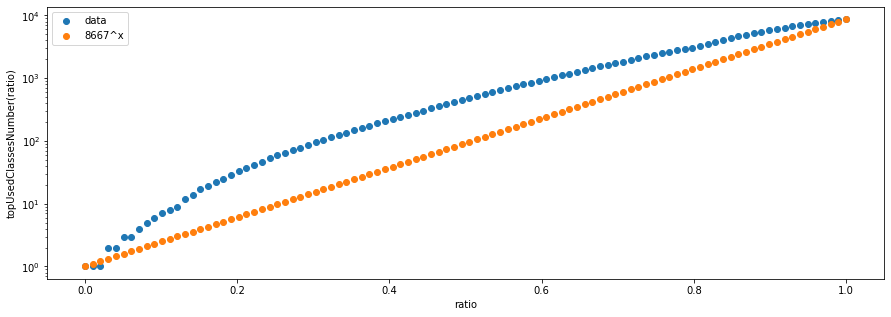

In [23]:
print_usagesRatioInfo('com.intellij.openapi.Disposable')

[('Action', 9657), ('An', 5127), ('Event', 3889), ('File', 2844), ('Project', 2527), ('Manager', 2395), ('Bundle', 2354), ('Util', 2000), ('Data', 1969), ('Psi', 1929)]
words = 158
names = 903
[('Action', 2410), ('Show', 214), ('Toggle', 175), ('Group', 152), ('To', 148), ('My', 120), ('Base', 99), ('Add', 92), ('File', 80), ('With', 75)]
words = 267
names = 2248


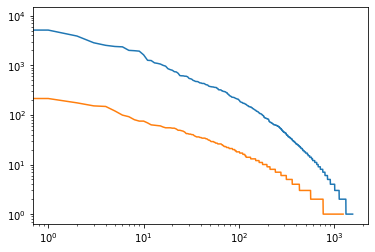

In [34]:
def splitCamelCase(name):
    return re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', name)).split()

def printWordPopularity(counter: Counter):
    wordCounter = Counter()
    for k, v in counter.most_common():
        for w in splitCamelCase(k.rpartition('.')[2]):
            wordCounter.update({w: v})

    _, ys = zip(*wordCounter.most_common())
    xs = range(0, len(ys))

    print(wordCounter.most_common()[:10])
    print(f'words = {getTopUsedClassesNumber(wordCounter, ratio=0.8)}')
    print(f'names = {getTopUsedClassesNumber(counter, ratio=0.8)}')
    plt.plot(xs, ys)
    plt.yscale('log')
    plt.xscale('log')


printWordPopularity(familyUsages['com.intellij.openapi.actionSystem.AnAction'])
printWordPopularity(Counter(family['com.intellij.openapi.actionSystem.AnAction']))